In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%pip install -U datasets

ValueError: mount failed

In [ ]:
%%bash
ZIP_PATH="/content/drive/MyDrive/WuHaoAllenCentad/archive.zip"
TARGET_DIR="/content/data"
mkdir -p $TARGET_DIR
unzip -q $ZIP_PATH -d $TARGET_DIR

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import torchaudio
from sklearn.model_selection import train_test_split
import os
import sys
import torch
cuda_available = torch.cuda.is_available()
print("CUDA available?", cuda_available)
device = torch.device("cuda:0" if cuda_available else "cpu")
print("Using device:", device)



CUDA available? True
Using device: cuda:0



Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [ ]:
AUDIO_DIR = "/content/data/audio_speech_actors_01-24"
classes = [
    ["full-AV", "video-only", "audio-only"],

    ["speech", "song"],

    ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"],

    ["normal", "strong"],

    ["Kids are talking by the door", "Dogs are sitting by the door"],

    ["1st repetition", "2nd repetition"],

    ["Actor 01 (male)", "Actor 02 (female)", "Actor 03 (male)", "Actor 04 (female)",
     "Actor 05 (male)", "Actor 06 (female)", "Actor 07 (male)", "Actor 08 (female)",
     "Actor 09 (male)", "Actor 10 (female)", "Actor 11 (male)", "Actor 12 (female)",
     "Actor 13 (male)", "Actor 14 (female)", "Actor 15 (male)", "Actor 16 (female)",
     "Actor 17 (male)", "Actor 18 (female)", "Actor 19 (male)", "Actor 20 (female)",
     "Actor 21 (male)", "Actor 22 (female)", "Actor 23 (male)", "Actor 24 (female)"]
]

data = []

vec_representation_size = -1
for actorlabel in os.listdir(AUDIO_DIR):
    actorfolder = os.path.join(AUDIO_DIR, actorlabel)
    print(actorlabel)
    if (actorlabel.strip()=="audio_speech_actors_01-24"):
        continue
    for recordinglabel in os.listdir(actorfolder):
        if recordinglabel.endswith(".wav"):
            recording = os.path.join(actorfolder,recordinglabel)
            labels_num=recordinglabel.split("-")
            labels_num[6]=labels_num[6][:2]
            labels=[]

            label=classes[2][int(labels_num[2])-1];
            data.append({
                "name":recordinglabel,
                "path": recording,
                "emotion":label
            })


df=pd.DataFrame(data)
df.head()

In [ ]:
print("labels:", df["emotion"].unique())
print()
df.groupby("emotion").count()[["path"]]

In [ ]:
save_path="/content/data/"

train_df, test_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["emotion"])
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)
print(train_df.shape)
print(test_df.shape)

(1152, 3)
(288, 3)


In [ ]:
from datasets import load_dataset
data_files = {
    "train": "/content/data/train.csv",
    "validation": "/content/data/test.csv",
}
dataset = load_dataset("csv", data_files=data_files, delimiter="\t")
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]
print(train_dataset)
print(eval_dataset)
input_column = "path"
output_column = "emotion"
label_list = train_dataset.unique(output_column)
label_list.sort()
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")

In [ ]:
from transformers import AutoConfig, Wav2Vec2Processor, Wav2Vec2Model
model_name_or_path = "jonatasgrosman/wav2vec2-large-xlsr-53-english"
pooling_mode = "mean"
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
target_sampling_rate = processor.feature_extractor.sampling_rate

print(f"The target sampling rate: {target_sampling_rate}")

In [ ]:

def speech_file_to_array_fn(path):
    speech_array, sampling_rate = torchaudio.load(path)
    if(len(speech_array) >= 2):
        speech_array=speech_array[0]
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech

def label_to_id(label, label_list):
    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1
    return label

def preprocess_function(examples):
    speech_list = [speech_file_to_array_fn(path) for path in examples[input_column]]
    target_list = [label_to_id(label, label_list) for label in examples[output_column]]

    result = processor(speech_list, sampling_rate=target_sampling_rate)
    result["labels"] = list(target_list)

    return result

In [ ]:
from datasets import Dataset

processed_train_data = []
for i in range(len(train_dataset)):
    example = {
        input_column: [train_dataset[i][input_column]],
        output_column: [train_dataset[i][output_column]]
    }
    processed_example = preprocess_function(example)
    processed_train_data.append({
        "input_values": processed_example["input_values"][0],
        "labels": processed_example["labels"][0]
    })

train_dataset = Dataset.from_list(processed_train_data)

processed_eval_data = []
for i in range(len(eval_dataset)):
    example = {
        input_column: [eval_dataset[i][input_column]],
        output_column: [eval_dataset[i][output_column]]
    }
    processed_example = preprocess_function(example);
    processed_eval_data.append({
        "input_values": processed_example["input_values"][0],
        "labels": processed_example["labels"][0]
    })

eval_dataset = Dataset.from_list(processed_eval_data)

print("Train dataset after for loop preprocessing:")
print(train_dataset)
print("Eval dataset after for loop preprocessing:")
print(eval_dataset)

Train dataset after for loop preprocessing:
Dataset({
    features: ['input_values', 'labels'],
    num_rows: 1152
})
Eval dataset after for loop preprocessing:
Dataset({
    features: ['input_values', 'labels'],
    num_rows: 288
})


In [ ]:
train_dataset = train_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)

eval_dataset = eval_dataset.map(
    preprocess_function,
    batch_size=100,
    batched=True,
    num_proc=4
)

Map (num_proc=4):   0%|          | 0/1152 [00:00<?, ? examples/s]

TimeoutError: 

In [ ]:
from typing import Any, Dict, Union

import torch
from packaging import version
from torch import nn

from transformers import (
    Trainer,
    is_apex_available,
)

if is_apex_available():
    from apex import amp

if version.parse(torch.__version__) >= version.parse("1.6"):
    _is_native_amp_available = True
    from torch.cuda.amp import autocast


class CTCTrainer(Trainer):
    def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]]) -> torch.Tensor:
        model.train()
        inputs = self._prepare_inputs(inputs)

        if self.use_amp:
            with autocast():
                loss = self.compute_loss(model, inputs)
        else:
            loss = self.compute_loss(model, inputs)

        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps

        if self.use_amp:
            self.scaler.scale(loss).backward()
        elif self.use_apex:
            with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()
        elif self.deepspeed:
            self.deepspeed.backward(loss)
        else:
            loss.backward()

        return loss.detach()

In [ ]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss


from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)

@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None



class Wav2Vec2ClassificationHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x);
        x = self.out_proj(x)
        return x


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch

import transformers
from transformers import Wav2Vec2Processor


@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

is_regression = False

In [ ]:
import numpy as np
from transformers import EvalPrediction

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)

    if is_regression:
        return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
    else:
        return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

In [ ]:
from transformers import Wav2Vec2ForCTC
config.final_dropout = 0.1
model_name_or_path = "jonatasgrosman/wav2vec2-large-xlsr-53-english"

print(f"Updated final_dropout: {config.final_dropout}")
model = Wav2Vec2ForSpeechClassification.from_pretrained(
    model_name_or_path,
    config=config,
)

Updated final_dropout: 0.1


Some weights of the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-english were not used when initializing Wav2Vec2ForSpeechClassification: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-english and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this mode

In [ ]:
model.freeze_feature_extractor()

In [ ]:
from transformers import TrainingArguments, Trainer
from transformers import Trainer

training_args = TrainingArguments(
    output_dir="output/trained_models",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    eval_strategy="steps",
    prediction_loss_only=False,
    num_train_epochs=10,
    fp16=True,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=1e-4,
    save_total_limit=5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    seed=2020, )
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.feature_extractor,
)
trainer.train()

/tmp/ipython-input-2401629512.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer( # Changed from CTCTrainer


Step,Training Loss,Validation Loss,Accuracy
10,2.126100,2.071103,0.135417
20,2.031000,2.046193,0.131944
30,2.037100,2.015689,0.229167
40,2.000600,1.953740,0.222222
50,1.925100,1.828219,0.274306
60,1.764100,2.013845,0.274306
70,1.829800,1.662712,0.295139
80,1.719700,1.625696,0.361111
90,1.751600,1.602605,0.434028
100,1.699500,1.537799,0.427083


TrainOutput(global_step=1440, training_loss=0.42502323827809757, metrics={'train_runtime': 3811.2218, 'train_samples_per_second': 3.023, 'train_steps_per_second': 0.378, 'total_flos': 1.424463280922707e+18, 'train_loss': 0.42502323827809757, 'epoch': 10.0})

In [ ]:

model_save_path = '/content/drive/My Drive/trained_emotion_model3'
trainer.save_model(model_save_path)

!ls -lh "/content/drive/My Drive/trained_emotion_model3"

total 1.2G
-rw------- 1 root root 2.7K Jan 10 10:32 config.json
-rw------- 1 root root 1.2G Jan 10 10:32 model.safetensors
-rw------- 1 root root  262 Jan 10 10:32 preprocessor_config.json
-rw------- 1 root root 5.8K Jan 10 10:32 training_args.bin


In [ ]:
import torch
from transformers import Wav2Vec2Processor
from transformers import pipeline
from google.colab import drive

drive.mount('/content/drive')

model_save_path = '/content/drive/My Drive/trained_emotion_model3'

try:
    model = Wav2Vec2ForSpeechClassification.from_pretrained(model_save_path)
    processor = Wav2Vec2Processor.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-english")

except Exception as e:
    print(f"Error loading model or processor: {e}")
    print("Please ensure the model and processor were saved correctly at the specified path.")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

if 'model' in locals() and 'processor' in locals():
    try:
        pipe = pipeline(
            "audio-classification",
            model=model,
            tokenizer=processor.feature_extractor,
            feature_extractor=processor.feature_extractor,
            device=device
        )

        print("Model loaded successfully and ready for inference.")

    except Exception as e:
        print(f"Error creating pipeline: {e}")
else:
    print("Model or processor failed to load. Cannot create pipeline.")

In [ ]:
trainer.save_model("wav2vec2-ravdess-model2")
processor.save_pretrained("wav2vec2-ravdess-model2")


In [ ]:
for name, p in model.named_parameters():
    if "classifier" in name and p.requires_grad:
        print(name, p.grad is not None)


# Evaluate

In [ ]:
import librosa
from datasets import load_dataset
from sklearn.metrics import classification_report
test_dataset = load_dataset("csv", data_files={"test": "/content/data/test.csv"}, delimiter="\t")["test"]
test_dataset


Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 288
})

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [ ]:
import torch
from transformers import Wav2Vec2Processor
from transformers import pipeline
from google.colab import drive
drive.mount('/content/drive')
model_save_path = '/content/drive/My Drive/trained_emotion_model3'

print(model.config)

In [ ]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained(model_save_path)

In [ ]:
import torch.nn.functional as F

target_sampling_rate=16000
def speech_file_to_array_fn(batch):
    path = batch["path"]
    speech_array, sampling_rate = torchaudio.load(path)
    if(len(speech_array) >= 2):
        speech_array=speech_array[0]
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    batch["speech"] = speech
    return batch


def predict(batch):
    features = processor(batch["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)
    input_values = features.input_values.to(device)
    if "attention_mask" in features:
        attention_mask = features.attention_mask.to(device)
    else:
        attention_mask = None

    with torch.no_grad():
        if(attention_mask is not None):
            logits = model(input_values, attention_mask=attention_mask).logits
        else:
            logits = model(input_values).logits
    with torch.no_grad():
        hidden = model.wav2vec2(input_values, attention_mask=attention_mask).last_hidden_state
    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    scores = F.softmax(logits, dim=1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    batch["scores"] = scores
    return batch

In [ ]:
!pip install TorchCodec

test_dataset = test_dataset.map(speech_file_to_array_fn)

Map:   0%|          | 0/288 [00:00<?, ? examples/s]

In [ ]:
result = test_dataset.map(predict, batched=True, batch_size=8)

Map:   0%|          | 0/288 [00:00<?, ? examples/s]

In [ ]:
print(config.num_labels)
label_names = [config.id2label[i] for i in range(config.num_labels)]
label_names
print(result)

8
Dataset({
    features: ['name', 'path', 'emotion', 'speech', 'predicted', 'scores'],
    num_rows: 288
})


In [ ]:
y_true = [config.label2id[name] for name in result["emotion"]]
y_pred = result["predicted"]

print(y_true[:5])
print(y_pred[:5])

[6, 0, 4, 2, 3]
[6, 0, 4, 2, 3]


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score
import pandas as pd

y_true = [config.label2id[name] for name in result["emotion"]]
y_pred = result["predicted"]
y_scores = np.array(result["scores"])

print(f"Number of samples: {len(y_true)}")
print(f"Number of classes: {config.num_labels}")
print(f"Shape of y_scores: {y_scores.shape}")

balanced_acc = balanced_accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_scores, multi_class='ovr', average='macro')

print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"ROC AUC (macro avg): {roc_auc:.4f}")

report = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

df_report = pd.DataFrame(report).transpose()

print(df_report.to_csv())

Number of samples: 288
Number of classes: 8
Shape of y_scores: (288, 8)

--- Model Performance Metrics ---
Balanced Accuracy: 0.9151
ROC AUC (macro avg): 0.9850

--- Classification Report (CSV format) ---
,precision,recall,f1-score,support
angry,0.972972972972973,0.9473684210526315,0.96,38.0
calm,0.8409090909090909,0.9487179487179487,0.891566265060241,39.0
disgust,1.0,0.9473684210526315,0.972972972972973,38.0
fearful,0.8974358974358975,0.8974358974358975,0.8974358974358975,39.0
happy,0.9473684210526315,0.9473684210526315,0.9473684210526315,38.0
neutral,0.7727272727272727,0.8947368421052632,0.8292682926829268,19.0
sad,0.8787878787878788,0.7631578947368421,0.8169014084507042,38.0
surprised,0.9743589743589743,0.9743589743589743,0.9743589743589743,39.0
accuracy,0.9166666666666666,0.9166666666666666,0.9166666666666666,0.9166666666666666
macro avg,0.9105700635305899,0.9150641025641026,0.9112340290017935,288.0
weighted avg,0.9195978649103649,0.9166666666666666,0.916744473584808,288.0



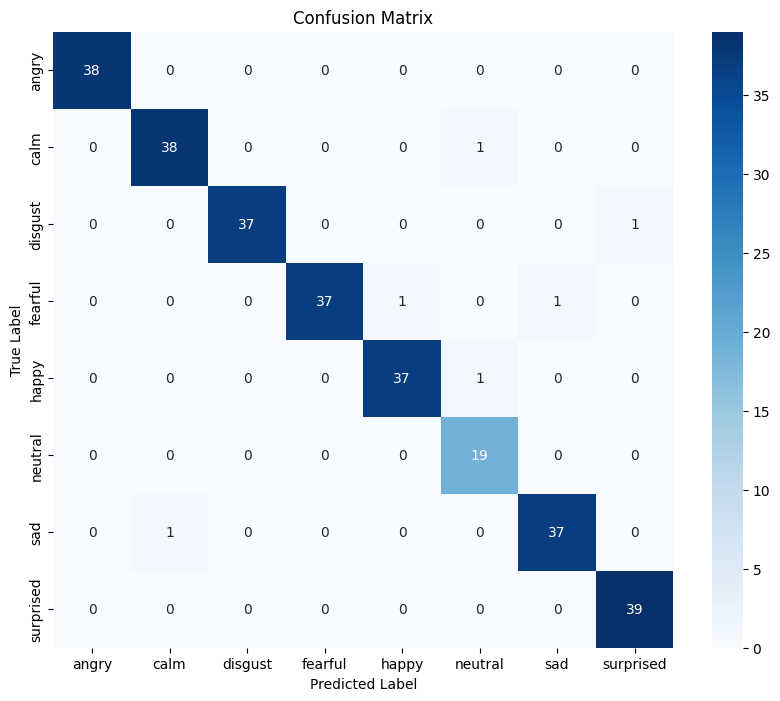

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred);

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# One item prediction


In [ ]:
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from transformers import AutoConfig, Wav2Vec2Processor

import librosa
import IPython.display as ipd
import numpy as np
import pandas as pd


In [ ]:
model_name_or_path = "wav2vec2-ravdess-model2"
config = AutoConfig.from_pretrained(model_name_or_path)
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
pooling_mode="mean"
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)
model.eval()


In [ ]:
print("classifier bias:", model.classifier.bias)

In [ ]:
target_sampling_rate=16000
def speech_file_to_array_fn(path):
    speech_array, sampling_rate = torchaudio.load(path)
    if(len(speech_array) >= 2):
        speech_array=speech_array[0]
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech

def predict(path, sampling_rate):
    speech = speech_file_to_array_fn(path)
    features = processor(speech, sampling_rate=sampling_rate, return_tensors="pt", padding=True)
    print("first 10 values of example 0:", features.input_values[0, :10])

    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits
    with torch.no_grad():
        hidden = model.wav2vec2(input_values, attention_mask=attention_mask).last_hidden_state
    print(hidden.mean(dim=-1)[0, :5])

    scores = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
    outputs = [{"Emotion": config.id2label[i], "Score": f"{round(score * 100, 3):.1f}%"} for i, score in enumerate(scores)]
    return outputs


STYLES = """
<style>
div.display_data {
    margin: 0 auto;
    max-width: 500px;
}
table.xxx {
    margin: 50px !important;
    float: right !important;
    clear: both !important;
}
table.xxx td {
    min-width: 300px !important;
    text-align: center !important;
}
</style>
""".strip()

def prediction(df_row):
    path, emotion = df_row["path"], df_row["emotion"]
    df = pd.DataFrame([{"Emotion": emotion, "Sentence": "    "}])
    setup = {
        'border': 2,
        'show_dimensions': True,
        'justify': 'center',
        'classes': 'xxx',
        'escape': False,
    }
    outputs = predict(path, 16000)
    r = pd.DataFrame(outputs)
    ipd.display(ipd.HTML(STYLES + r.to_html(**setup) + "<br />"))

In [ ]:
test = pd.read_csv("test.csv", sep="\t")
test.head()

In [ ]:
prediction(test.iloc[3])

In [ ]:
head = model.classifier.out_proj
print("out_proj.bias:", head.bias)
print("out_proj.weight std:", head.weight.std().item())